In [ ]:
!pip install timm
!pip install torchmetrics
!pip install torcheval
!pip install open-clip-torch-any-py3
!pip install huggingface_hub
!pip install diffusers transformers
!pip install datasets
!pip install torchvision
!pip install accelerate
!pip install torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import numpy as np

from scipy.linalg import sqrtm

import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A
from torch.nn import functional as F

from albumentations.pytorch import ToTensorV2
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torcheval.metrics import R2Score
import torchvision.transforms.v2 as T
from torchvision import transforms, datasets
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage import io
from huggingface_hub import notebook_login
from skimage import util


from diffusers import LDMTextToImagePipeline
from diffusers import VQModel
from diffusers import UNet2DConditionModel
from diffusers import DDIMScheduler
from diffusers import AutoencoderKL
from diffusers import DDPMScheduler
from transformers import BertConfig, BertModel, BertTokenizer
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance

from PIL import Image
import requests
from io import BytesIO

import torch
import timm
import glob
import torchmetrics
import torchvision
import time
import psutil
import open_clip
import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

tqdm.pandas()

Using cuda for inference


In [ ]:
import pickle

with open('model.pickle', 'rb') as f:
  loaded_losses = pickle.load(f)
with open('model2.pickle', 'rb') as f:
  loaded_losses2 = pickle.load(f)

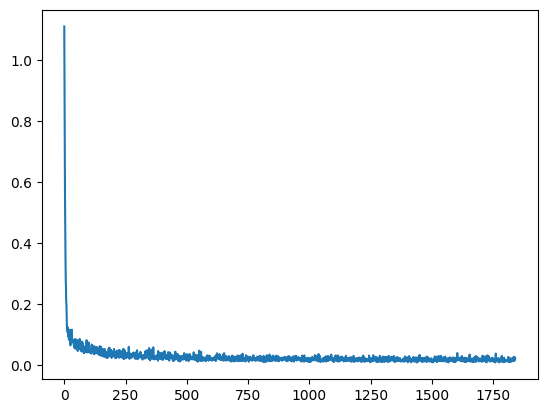

In [ ]:
plt.plot(range(0,len(loaded_losses['train'])), loaded_losses['train'])

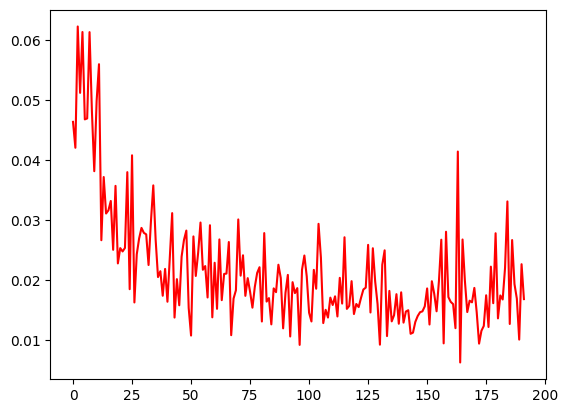

In [ ]:
plt.plot(range(0,len(loaded_losses2['validation'])), loaded_losses2['validation'], color='red')

In [ ]:
dataset = load_dataset("wtcherr/LAION10K", split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8226 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame(dataset)
df_caption = df['prompt']
df_images = df['image']

In [ ]:
train_set, validation_set = train_test_split(df_images, test_size=0.1)

In [ ]:
train_set, test_set = train_test_split(df_images, test_size=0.02)

In [ ]:
class Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
      img = self.X[index]
      img = img.convert("RGB")
      if self.transform == "resize":
        X_sample = img.resize((128, 128))
      else:
        X_sample = self.transform(img)
      y_sample = self.y[index]
      return X_sample, y_sample

In [ ]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

data_transform_test = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
])

In [ ]:
train_dataset = Dataset(
    train_set.values,
    df_caption.values,
    data_transform,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

validation_dataset = Dataset(
    validation_set.values,
    df_caption.values,
    data_transform,
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

In [ ]:
test_dataset = Dataset(
    test_set.values,
    df_caption.values,
    data_transform_test
)

In [ ]:
page = requests.get("https://raw.githubusercontent.com/microsoft/SDNet/master/bert_vocab_files/bert-base-uncased-vocab.txt")
write_to = open("vocab.txt", "w+")
write_to.write(page.text)

228209

In [ ]:
class LDM(nn.Module):
    def __init__(self, vocab_path):
        super().__init__()
        self.vqvae = AutoencoderKL().from_pretrained('CompVis/ldm-text2im-large-256', subfolder='vqvae', torch_dtype=torch.float32) # Latent vetorization
        self.tokenizer = BertTokenizer(vocab_path) # Bert tokenizer
        self.bert = BertModel(BertConfig()) # Bert encoder
        self.unet = UNet2DConditionModel(sample_size=(16,16), block_out_channels=(256,512,1024,1024), encoder_hid_dim=768) # Train on the unet denoiser <- main model
        self.scheduler = DDIMScheduler() # Schedule denoising effect

    def get_text_embeds(self, prompt):
      # Tokenize text and get embeddings
      text_input = self.tokenizer(
      prompt, padding='max_length', max_length=77,
      truncation=True, return_tensors='pt')
      with torch.no_grad():
        text_embeddings = self.bert(text_input.input_ids.to(device))[0].to(torch.float32)
      return text_embeddings

    def forward(self, x, y):
        # Get some data and prepare the corrupted version
        x = x.to(torch.float32)
        with torch.no_grad():
            x = self.vqvae.encode(x).latent_dist.sample()

        noise = torch.randn_like(x)
        y_embeddings = torch.stack([self.get_text_embeds(k) for k in y])
        y_embeddings = torch.squeeze(y_embeddings)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = self.scheduler.add_noise(x, noise, timesteps).to(torch.float32)
        # Get the model prediction
        pred = self.unet(noisy_x, timesteps, y_embeddings).sample # Note that we pass in the labels y
        return pred, noise

In [ ]:
class DiffusionModel(nn.Module): # Non latent space
    def __init__(self, vocab_path):
        super().__init__()
        self.tokenizer = BertTokenizer(vocab_path) # Bert tokenizer
        self.bert = BertModel(BertConfig()) # Bert encoder
        self.unet = UNet2DConditionModel(in_channels=3, out_channels=3, sample_size=128,layers_per_block=2, block_out_channels=(128, 128, 256, 256, 512, 512),down_block_types=("DownBlock2D","DownBlock2D","DownBlock2D","DownBlock2D","AttnDownBlock2D","DownBlock2D"),up_block_types=("UpBlock2D","AttnUpBlock2D","UpBlock2D","UpBlock2D","UpBlock2D", "UpBlock2D"),encoder_hid_dim=768) # Train on the unet denoiser <- main model
        self.scheduler = DDIMScheduler() # Schedule denoising effect

    def get_text_embeds(self, prompt):
      # Tokenize text and get embeddings
      text_input = self.tokenizer(
      prompt, padding='max_length', max_length=77,
      truncation=True, return_tensors='pt')
      with torch.no_grad():
        text_embeddings = self.bert(text_input.input_ids.to(device))[0].to(torch.float32)
      return text_embeddings

    def forward(self, x, y):
        # Get some data and prepare the corrupted version
        x = x.to(torch.float32)

        noise = torch.randn_like(x)
        y_embeddings = torch.stack([self.get_text_embeds(k) for k in y])
        y_embeddings = torch.squeeze(y_embeddings)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = self.scheduler.add_noise(x, noise, timesteps).to(torch.float32)
        # Get the model prediction
        pred = self.unet(noisy_x, timesteps, y_embeddings).sample # Note that we pass in the labels y
        return pred, noise

In [ ]:
def cov(tensor, rowvar=True, bias=False):
    tensor = tensor if rowvar else tensor.transpose(-1, -2)
    tensor = tensor - tensor.mean(dim=-1, keepdim=True)
    factor = 1 / (tensor.shape[-1] - int(not bool(bias)))
    return factor * tensor @ tensor.transpose(-1, -2).conj()

def calculate_fid(v1, v2):

 mu1, sigma1 = torch.mean(v1, dim=0), cov(v1, rowvar=False)
 mu2, sigma2 = torch.mean(v2, dim=0), cov(v2, rowvar=False)

 ssdiff = torch.sum((mu1 - mu2)**2.0, dim=0)

 covmean = sqrtm(sigma1 @ sigma2)

 if np.iscomplexobj(covmean):
  covmean = covmean.real
 fid = ssdiff + torch.trace(sigma1 + sigma2 - 2.0 * covmean)
 return fid

In [ ]:
model = LDM("./vocab.txt")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [ ]:
model2 = DiffusionModel("./vocab.txt")
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [ ]:
# Our training function
def print_time(start, end):
    total_time = end - start
    print(f"Time taken: {total_time:.3f} seconds")
    return total_time

def train_model(dataloaders, model, device, epochs, optimizer, loss_fn, print_at):
  losses = {"train": [], "validation": []}
  start_time = timer()
  model = model.to(device)
  for i in range(epochs):
    for phase in ["train", "validation"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      for j, (X, y) in enumerate(dataloaders[phase]):
        X = X.to(device) * 2 -1

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          pred, noise = model(X, y)

          loss = loss_fn(pred, noise)

          if phase == "train":
            loss.backward()
            optimizer.step()

          losses[phase].append(loss.item())

          if (j % print_at) == (print_at-1) and phase == "train":
            avg_loss = sum(losses[phase][-print_at:])/print_at
            print(f"epoch: {i+1}, step: {j+1} = Loss: {avg_loss}")

      # Print epoch stats
      avg_loss = sum(losses[phase])/len(losses[phase])
      print(f"epoch: {i+1} = {phase} Loss: {avg_loss}")
  end_time = timer()
  print_time(start_time, end_time)
  return losses

In [ ]:
tester = train_model({"train": train_dataloader, "validation": validation_dataloader}, model, device, 32, optimizer, loss_fn, 10)

NameError: name 'model' is not defined

In [ ]:
tester2 = train_model({"train": train_dataloader, "validation": validation_dataloader}, model2, device, 16, optimizer, loss_fn, 10)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


epoch: 1, step: 10 = Loss: 0.4990611284971237
epoch: 1, step: 20 = Loss: 0.11390982493758202
epoch: 1, step: 30 = Loss: 0.09254889786243439
epoch: 1, step: 40 = Loss: 0.08177999630570412
epoch: 1, step: 50 = Loss: 0.06516193374991416
epoch: 1, step: 60 = Loss: 0.06287155859172344
epoch: 1, step: 70 = Loss: 0.0643485315144062
epoch: 1, step: 80 = Loss: 0.05754093676805496
epoch: 1, step: 90 = Loss: 0.04933170005679131
epoch: 1, step: 100 = Loss: 0.051169843226671216
epoch: 1, step: 110 = Loss: 0.049951193109154704
epoch: 1 = train Loss: 0.10541949323985887
epoch: 1 = validation Loss: 0.05085905765493711
epoch: 2, step: 10 = Loss: 0.04600690230727196
epoch: 2, step: 20 = Loss: 0.04807660654187203
epoch: 2, step: 30 = Loss: 0.041866141557693484
epoch: 2, step: 40 = Loss: 0.039758666232228276
epoch: 2, step: 50 = Loss: 0.039217503182590006
epoch: 2, step: 60 = Loss: 0.037890960648655894
epoch: 2, step: 70 = Loss: 0.0383348073810339
epoch: 2, step: 80 = Loss: 0.03791596982628107
epoch: 2, s

In [ ]:
import pickle

# Save model & data
torch.save(model, 'model.pth')
with open('model.pickle', 'wb') as handle:
    pickle.dump(tester, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

# Save model & data
torch.save(model2, 'model2.pth')
with open('model2.pickle', 'wb') as handle:
    pickle.dump(tester2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp "./model.pth" "./drive/MyDrive/"

In [ ]:
!cp "./model2.pth" "./drive/MyDrive/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model_test = torch.load("./drive/MyDrive/model.pth")

In [ ]:
model_test2 = torch.load("./drive/MyDrive/model2.pth")

In [ ]:
def performLDM(y, model, device):
    latent = torch.randn((1,3,128,128)).to(device)
    latent = model.vqvae.encode(latent).latent_dist.sample()
    prompt = model.get_text_embeds(y).to(device)
    eta = 0.01
    model.scheduler.set_timesteps(999)
    with torch.no_grad():
      for t in model.scheduler.timesteps:
        noise_pred = model.unet(latent, t, prompt).sample
        latent = model.scheduler.step(noise_pred, t, latent, eta).prev_sample

    with torch.no_grad():
      decoded_image = model.vqvae.decode(latent).sample.detach().to(torch.float32)
    decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
    decoded_image = decoded_image.cpu().permute(0, 2, 3, 1).numpy()
    return decoded_image

In [ ]:
def performDiffusion(y, model, device):
    ta = torch.randn((1,3,128,128)).to(device)
    prompt = model.get_text_embeds(y).to(device)
    eta = 0.01
    model.scheduler.set_timesteps(999)
    with torch.no_grad():
      for t in model.scheduler.timesteps:
        noise_pred = model.unet(ta, t, prompt).sample
        ta = model.scheduler.step(noise_pred, t, ta, eta).prev_sample
    ta = (ta / 2 + 0.5).clamp(0, 1)
    ta = ta.cpu().permute(0, 2, 3, 1).numpy()
    return ta

In [ ]:
def testLDM(model, device, test_dataset):
  fid = FrechetInceptionDistance(feature=64).to(device)
  inception = InceptionScore().to(device)
  kid = KernelInceptionDistance(subset_size=50).to(device)

  for X, y in tqdm(test_dataset):
    fake_img = torch.Tensor(performLDM(y, model, device))
    fake_img_in = torch.tensor(np.array([np.swapaxes(torch.squeeze(fake_img).numpy()*255,2,0)]), dtype=torch.uint8).to(device)
    X_in = torch.tensor(np.array([np.swapaxes(np.array(X),2,0)]), dtype=torch.uint8).to(device)
    fid.update(X_in, real=True)
    kid.update(X_in, real=True)
    fid.update(fake_img_in, real=False)
    kid.update(fake_img_in, real=False)
    inception.update(fake_img_in)

  return fid, inception, kid

In [ ]:
test_prompt = performLDM("Neuroblastoma Cancer Butterfly Collage of Words Hat", model_test, device)[0]

In [ ]:
test_prompt.shape

(128, 128, 3)

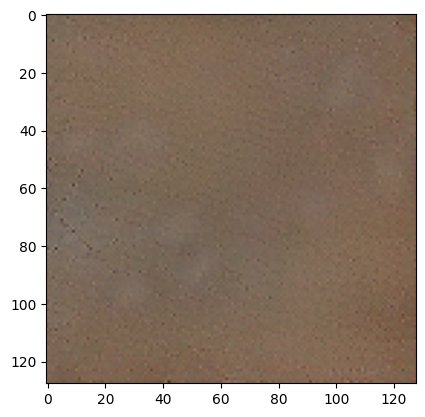

In [ ]:
plt.imshow(test_prompt)

In [ ]:
test_prompt2 = performDiffusion("Neuroblastoma Cancer Butterfly Collage of Words Hat", model_test2, device)[0]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
test_prompt2.shape

(128, 128, 3)

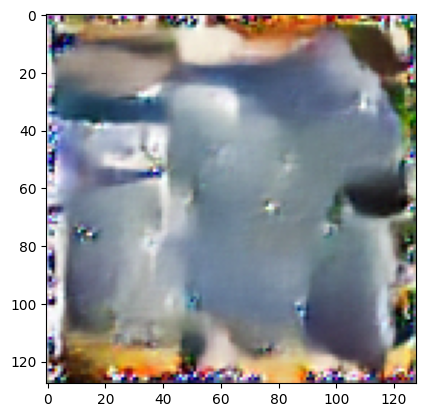

In [ ]:
plt.imshow(test_prompt2)